In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import numpy as np
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
from sklearn.metrics import mean_squared_error
import logging
import os
import time
from ipywidgets import widgets
from IPython.display import display
from ipywidgets import interact, interact_manual
import matplotlib.style as style

is_update_model = False


Using TensorFlow backend.


In [2]:
df = pd.read_excel('Book288.xlsx')
df = df.dropna(axis='columns',how='all')
df.drop(df.columns[0],axis=1,inplace=True)
df.columns= df.iloc[1]
df = df[2:]
df.head()

1,Timestamp,Trade High,Trade Low,Trade Open,Trade Close,Trade Count,Trade Volume
2,2019-05-23 13:30:00,625.75,624.75,624.75,625.25,210,659
3,2019-05-23 13:00:00,625,623.75,623.75,624.75,713,1877
4,2019-05-23 12:30:00,624.5,623.5,624.25,624,392,1046
5,2019-05-23 12:00:00,625.75,623.25,625.25,624.25,1219,5027
6,2019-05-23 11:30:00,629.5,625.25,629,625.25,760,3894


In [3]:
print(df.shape[0],df.dropna().shape[0])
train_cols = ['Trade High','Trade Low','Trade Open','Trade Close','Trade Volume']
if 'Trade Count' in df.columns :
    df.drop(['Trade Count'] , axis='columns', inplace=True)
for i in train_cols:
    df[i]= df[i].astype(float).interpolate(method='spline',order=3)
#c = df['Trade High'].astype(float).interpolate(method='linear',order=3)
print(df.shape[0],df.dropna().shape[0])
#print(c[c.isnull()])
df.head()

10634 10386
10634 10634


1,Timestamp,Trade High,Trade Low,Trade Open,Trade Close,Trade Volume
2,2019-05-23 13:30:00,625.75,624.75,624.75,625.25,659.0
3,2019-05-23 13:00:00,625.00,623.75,623.75,624.75,1877.0
4,2019-05-23 12:30:00,624.50,623.50,624.25,624.00,1046.0
5,2019-05-23 12:00:00,625.75,623.25,625.25,624.25,5027.0
6,2019-05-23 11:30:00,629.50,625.25,629.00,625.25,3894.0


C:\Users\Janak.Agrawal\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



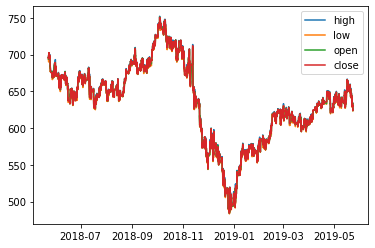

In [4]:
plt.plot(df['Timestamp'],df['Trade High'])
plt.plot(df['Timestamp'],df['Trade Low'])
plt.plot(df['Timestamp'],df['Trade Open'])
plt.plot(df['Timestamp'],df['Trade Close'])
plt.legend(['high','low','open','close'])
plt.show()

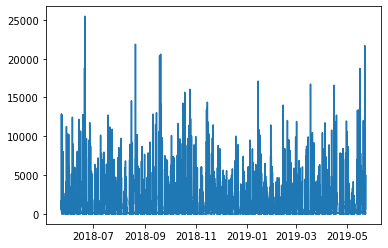

In [5]:
plt.plot(df['Timestamp'],df['Trade Volume'])
plt.show()

In [6]:
type(df['Timestamp'].iloc[0])
df.sort_values('Timestamp',inplace=True)    
df = df.reset_index()
df = df.drop('index',axis=1)
df.head()

1,Timestamp,Trade High,Trade Low,Trade Open,Trade Close,Trade Volume
0,2018-05-23 12:30:00,695.50,693.50,693.75,695.25,1669.0
1,2018-05-23 13:00:00,695.50,694.25,695.00,695.00,2130.0
2,2018-05-23 13:30:00,697.25,694.75,695.00,696.75,2867.0
3,2018-05-23 14:00:00,697.00,695.25,696.75,695.50,571.0
4,2018-05-23 14:30:00,695.75,693.75,695.75,695.25,3041.0


In [7]:
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])
x_train

Train and Test size 8507 2127


array([[0.78725398, 0.79339623, 0.78484565, 0.79174484, 0.0654991 ],
       [0.78725398, 0.79622642, 0.78952292, 0.79080675, 0.08360166],
       [0.79381443, 0.79811321, 0.78952292, 0.79737336, 0.11254221],
       ...,
       [0.4995314 , 0.50660377, 0.50233863, 0.50187617, 0.04543313],
       [0.50609185, 0.50660377, 0.50046773, 0.50469043, 0.07154638],
       [0.50140581, 0.50283019, 0.505145  , 0.49812383, 0.17513547]])

In [8]:
def build_timeseries(mat, y_col_index,TIME_STEPS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
#    for i in tqdm_notebook(range(dim_0)):
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    #print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [9]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [10]:
BATCH_SIZE = 200
TIME_STEPS = 720
target_col = 3
lr = 0.001
OUTPUT_PATH = 'prediction_output/'
epoch = 4

In [11]:
x_t, y_t = build_timeseries(x_train,target_col,TIME_STEPS )
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test,target_col, TIME_STEPS)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

In [12]:
def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='linear'))
    optimizer = optimizers.RMSprop(lr=lr)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model

In [13]:
model = None
try:
    model = pickle.load(open(OUTPUT_PATH+"lstm_model", 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Loaded saved model...


In [14]:
if model is None or is_update_model:
    from keras import backend as K
    print("Building model...")
    print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model = create_model()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                          "best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

    # Not used here. But leaving it here as a reminder for future
    r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
                                  verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + '.log'), append=True)
    
    history = model.fit(x_t, y_t, epochs=epoch, verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])
    
    print("saving model...")
    pickle.dump(model, open(OUTPUT_PATH+"lstm_model", "wb"))
    
    y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
    y_pred = y_pred.flatten()
    y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
    error = mean_squared_error(y_test_t, y_pred)
    print("Error is", error, y_pred.shape, y_test_t.shape)
    print(y_pred[0:15])
    print(y_test_t[0:15])

    # convert the predicted value to range of real data
    y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
    # min_max_scaler.inverse_transform(y_pred)
    y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
    # min_max_scaler.inverse_transform(y_test_t)
    print(y_pred_org[0:15])
    print(y_test_t_org[0:15])

    # Visualize the training data
    from matplotlib import pyplot as plt
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    #plt.show()

In [15]:
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
print(saved_model)

y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot([x/48.0 for x in range(len(y_pred_org))],y_pred_org)
plt.plot([x/48.0 for x in range(len(y_pred_org))],y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()

InvalidArgumentError: Incompatible shapes: [200,100] vs. [20,100]
	 [[{{node lstm_1_1/while/add_7}}]]

In [ ]:
print("Select date between " + str(df['Timestamp'].iloc[TIME_STEPS+1].date()) +" and " + str(df['Timestamp'].iloc[-1].date())+".")
@interact
def predict_price(days = [7,10,30],date=widgets.DatePicker(value=pd.to_datetime(df['Timestamp'].iloc[721])),theme=list(style.available)):
    d = pd.to_datetime(date)
    #print(d)
    if len(df[d==df['Timestamp'].dt.date]) < 1:
           print("Date out of range! Select again")
    else:
        i = df[d==df['Timestamp'].dt.date].index.values.astype(int)[0]
        #print(i)
        da = days*48
        print(da)
        df_test = df.loc[:i+500]
        x_test = min_max_scaler.transform(df_test.loc[:,train_cols])
        #print(x_test.shape)
        x_test_t, y_test_t = build_timeseries(x_test,target_col, TIME_STEPS)
        y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
        y_pred = y_pred.flatten()
        y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
        error = mean_squared_error(y_test_t, y_pred)
        #print("Error is", error, y_pred.shape, y_test_t.shape)
        #print(y_pred[0:15])
        #print(y_test_t[0:15])
        y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
        y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
        #print(y_pred_org[0:15])
        #print(y_test_t_org[0:15])

        # Visualize the prediction
        from matplotlib import pyplot as plt
        plt.figure()
        style.use(theme)
        #print([d + pd.DateOffset(hours=x/2.0) for x in range(len(y_pred_org))])
        plt.plot([d + pd.DateOffset(hours=x/2.0) for x in range(len(y_pred_org))],y_pred_org)
        plt.plot([d + pd.DateOffset(hours=x/2.0) for x in range(len(y_pred_org))],y_test_t_org)
        plt.title('Prediction vs Real Stock Price')
        plt.ylabel('Price')
        plt.xlabel('Days')
        plt.xticks(rotation=90)
        plt.legend(['Prediction', 'Real'], loc='upper left')
        plt.show()